# ODIN

**Abstract**

We consider the problem of detecting out-of-distribution images in neural networks.
We propose ODIN, a simple and effective method that does not require any change
to a pre-trained neural network. Our method is based on the observation that using
temperature scaling and adding small perturbations to the input can separate the
softmax score distributions between in- and out-of-distribution images, allowing
for more effective detection. 

<center>
<img src='https://github.com/ShiyuLiang/odin-pytorch/raw/master/figures/original_optimal_shade.png' width=400>
</center>


**Temperature Scaling**

Prior works have established
the use of temperature scaling to distill the knowledge in neural networks (Hinton et al., 2015) and calibrate the prediction confidence in classification tasks (Guo et al., 2017)


$$
S_i(x;T) = \frac{\exp(f_i(x)/T)}{\sum_{j=1}^N \exp(f_j(x)/T)}
$$


**Input preprocessing**

The method is inspired by the
idea in the reference (Goodfellow et al., 2015), where small perturbations are added to decrease the
softmax score for the true label and force the neural network to make a wrong prediction. Here, our
goal and setting are rather different: we aim to increase the softmax score of any given input, without
the need for a class label at all.

$$
\tilde{x} = x - \epsilon \mbox{sign}(- \nabla_x \log S_{\hat{y}}(x;T))
$$



In [0]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.autograd import Variable

import torch.nn.functional as F
from skimage.transform import resize
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline  

## Define: model


In [2]:
model = torchvision.models.resnet18(pretrained=True)
model.fc = nn.Linear(512, 10)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth
100%|██████████| 44.7M/44.7M [00:02<00:00, 17.1MB/s]


In [0]:
batch_size = 64
learning_rate = 0.0001
num_epoch = 10

In [4]:
mnist_train = dset.MNIST("./", train=True, 
                         transform=transforms.Compose([
                            transforms.ToTensor(),
                         ]), 
                         target_transform=None, 
                         download=True)

mnist_test = dset.MNIST("./", train=False, 
                         transform=transforms.Compose([
                            transforms.ToTensor(),
                         ]), 
                         target_transform=None, 
                         download=True)

fashionMNIST = dset.FashionMNIST("./", train=False,
                        transform=transforms.Compose([
                            transforms.ToTensor(),
                        ]),
                        target_transform=None, 
                        download=True)

train_loader = torch.utils.data.DataLoader(mnist_train,batch_size=batch_size, shuffle=True,num_workers=2,drop_last=True)
test_loader = torch.utils.data.DataLoader(mnist_test,batch_size=batch_size, shuffle=True,num_workers=2,drop_last=True)
fashion_loader = torch.utils.data.DataLoader(fashionMNIST,batch_size=batch_size, shuffle=True,num_workers=2,drop_last=True)

  0%|          | 16384/9912422 [00:00<01:28, 111215.10it/s]

9920512it [00:00, 29677865.20it/s]                           


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw


32768it [00:00, 453587.92it/s]
  1%|          | 16384/1648877 [00:00<00:11, 144023.42it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw


1654784it [00:00, 7071489.71it/s]                           
8192it [00:00, 188012.93it/s]
0it [00:00, ?it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw
Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw
Processing...
Done!


26427392it [00:01, 14812894.07it/s]                              


Extracting ./FashionMNIST/raw/train-images-idx3-ubyte.gz to ./FashionMNIST/raw


0it [00:00, ?it/s]

32768it [00:00, 102009.14it/s]           
0it [00:00, ?it/s]

Extracting ./FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./FashionMNIST/raw


4423680it [00:01, 4198398.30it/s]                             
0it [00:00, ?it/s]

Extracting ./FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./FashionMNIST/raw


8192it [00:00, 30410.56it/s]            

Extracting ./FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./FashionMNIST/raw
Processing...
Done!


## Train

In [5]:
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
model.cuda()
for i in range(num_epoch):
    model.train()
    for j,[image,label] in enumerate(train_loader):
        x = Variable(image)
        x = torch.cat([x, x, x], dim=1).type(torch.FloatTensor).cuda()
        y_= Variable(label).cuda()
        optimizer.zero_grad()
        output = model.forward(x)
        loss = loss_func(output,y_)
        loss.backward()
        optimizer.step()
        
         
    top_1_count = torch.FloatTensor([0])
    total = torch.FloatTensor([0])
    model.eval() 
    for image,label in test_loader:
        x = Variable(image)
        x = torch.cat([x, x, x], dim=1).type(torch.FloatTensor).cuda()
        y_= Variable(label).cuda()

        output = model.forward(x)
        
        values,idx = output.max(dim=1)
        top_1_count += torch.sum(y_==idx).float().cpu().data

        total += label.size(0)

    print("Test Data Accuracy: {}%".format(100*(top_1_count/total).numpy()))
    if (top_1_count/total).numpy() > 0.98:
        break

Test Data Accuracy: [98.788055]%


# In-distribution

In [0]:
base_in = []
temp_in = []
odin_in = []
T = 1e+4
noise = 1e-4

In [0]:
for i, (images, _) in enumerate(test_loader):
    if i > 10: break
    inputs = Variable(images.cuda(), requires_grad=True)
    inputs = torch.cat([inputs, inputs, inputs], dim=1).type(torch.FloatTensor).cuda()
    inputs.retain_grad()
    outputs = model(inputs)
    outputs_base = outputs.data.cpu().numpy()

    # baseline
    outputs_base = outputs_base - np.max(outputs_base, axis=0)
    outputs_base = np.exp(outputs_base) / np.sum(np.exp(outputs_base))
    base_in += list(np.max(outputs_base, axis=1))

    # temperature
    outputs_temp = outputs.data.cpu().numpy()
    outputs_temp /= T
    outputs_temp = outputs_temp - np.max(outputs_temp, axis=0)
    outputs_temp = np.exp(outputs_temp) / np.sum(np.exp(outputs_temp))
    temp_in += list(np.max(outputs_temp, axis=1))

    # ODIN: temperature + input preprocessing
    outputs_odin = outputs.data.cpu().numpy()
    outputs_odin /= T
    max_idx = np.argmax(outputs_odin, axis=1)
    labels = Variable(torch.LongTensor(max_idx)).cuda()
    loss = loss_func(outputs, labels)
    loss.backward()
    
    # gradient = torch.ge(inputs.grad.data, 0)
    # gradient = (gradient.float() - 0.5) * 2
    preprocessed = torch.add(inputs.data, -noise, gradient)
    outputs = model(preprocessed)
    outputs_odin = outputs.data.cpu().numpy()
    outputs_odin /= T
    outputs_odin = outputs_odin - np.max(outputs_odin, axis=0)
    outputs_odin = np.exp(outputs_odin) / np.sum(np.exp(outputs_odin))
    odin_in += list(np.max(outputs_odin, axis=1))





## Out-of-distribution

In [0]:
base_out = []
temp_out = []
odin_out = []
T = 1e+4
noise = 1e-4

In [0]:
for i, (images, _) in enumerate(fashion_loader):
    if i > 10: break
    inputs = Variable(images.cuda(), requires_grad=True)
    inputs = torch.cat([inputs, inputs, inputs], dim=1).type(torch.FloatTensor).cuda()
    inputs.retain_grad()
    outputs = model(inputs)
    outputs_base = outputs.data.cpu().numpy()

    # baseline
    outputs_base = outputs_base - np.max(outputs_base, axis=0)
    outputs_base = np.exp(outputs_base) / np.sum(np.exp(outputs_base))
    base_out += list(np.max(outputs_base, axis=1))

    # temperature
    outputs_temp = outputs.data.cpu().numpy()
    outputs_temp /= T
    outputs_temp = outputs_temp - np.max(outputs_temp, axis=0)
    outputs_temp = np.exp(outputs_temp) / np.sum(np.exp(outputs_temp))
    temp_out += list(np.max(outputs_temp, axis=1))

    # ODIN: temperature + input preprocessing
    outputs_odin = outputs.data.cpu().numpy()
    outputs_odin /= T
    max_idx = np.argmax(outputs_odin, axis=1)
    labels = Variable(torch.LongTensor(max_idx)).cuda()
    loss = loss_func(outputs, labels)
    loss.backward()
    
    # gradient = torch.ge(inputs.grad.data, 0)
    # gradient = (gradient.float() - 0.5) * 2

    preprocessed = torch.add(inputs.data, -noise, gradient)
    outputs = model(preprocessed)
    outputs_odin = outputs.data.cpu().numpy()
    outputs_odin /= T
    outputs_odin = outputs_odin - np.max(outputs_odin, axis=0)
    outputs_odin = np.exp(outputs_odin) / np.sum(np.exp(outputs_odin))
    odin_out += list(np.max(outputs_odin, axis=1))


## Define metric: ROC-curve

In [0]:
from typing import List
from sklearn import metrics

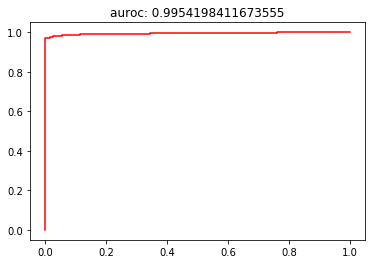

In [44]:
labels = [1] * len(odin_in)  + [0] * len(odin_out)
scores = odin_in + odin_out
fpr, tpr, thresholds = metrics.roc_curve(labels, scores, pos_label=1)
roc_score = metrics.roc_auc_score(labels, scores)
plt.plot(fpr, tpr, color='r')
plt.title('auroc: {}'.format(roc_score))
plt.show()



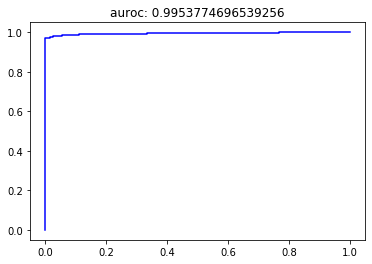

In [45]:
labels = [1] * len(temp_in)  + [0] * len(temp_out)
scores = temp_in + temp_out
fpr, tpr, thresholds = metrics.roc_curve(labels, scores, pos_label=1)
roc_score = metrics.roc_auc_score(labels, scores)
plt.plot(fpr, tpr, color='b')
plt.title('auroc: {}'.format(roc_score))
plt.show()


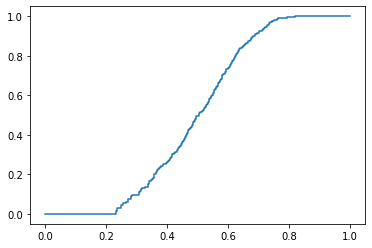

In [27]:
labels = [1] * len(base_in)  + [0] * len(base_out)
scores = base_in + base_out
fpr, tpr, thresholds = metrics.roc_curve(labels, scores, pos_label=0)
plt.plot(fpr, tpr)
plt.show()